In [1]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [2]:
import os
import shutil
from sklearn.model_selection import train_test_split

source_dir = "/content/dataset"
train_dir = "/content/data_split/train"
val_dir = "/content/data_split/val"

# Her sınıf için ayrı işle
for class_name in ["bird", "drone"]:
    files = os.listdir(os.path.join(source_dir, class_name))
    train_files, val_files = train_test_split(files, test_size=0.2, random_state=42)

    # Eğitim klasörü
    os.makedirs(os.path.join(train_dir, class_name), exist_ok=True)
    for file in train_files:
        src = os.path.join(source_dir, class_name, file)
        dst = os.path.join(train_dir, class_name, file)
        shutil.copyfile(src, dst)

    # Validasyon klasörü
    os.makedirs(os.path.join(val_dir, class_name), exist_ok=True)
    for file in val_files:
        src = os.path.join(source_dir, class_name, file)
        dst = os.path.join(val_dir, class_name, file)
        shutil.copyfile(src, dst)

print("✅ Veriler eğitim ve doğrulama olarak ayrıldı.")


✅ Veriler eğitim ve doğrulama olarak ayrıldı.


In [3]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms, models
from torch.optim.lr_scheduler import CosineAnnealingLR
from torch.utils.data import DataLoader
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns


In [4]:
data_dir = "/content/data_split"

train_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.ColorJitter(brightness=0.2, contrast=0.2),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])

val_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])

train_data = datasets.ImageFolder(os.path.join(data_dir, "train"), transform=train_transforms)
val_data = datasets.ImageFolder(os.path.join(data_dir, "val"), transform=val_transforms)

train_loader = DataLoader(train_data, batch_size=32, shuffle=True, num_workers=2)
val_loader = DataLoader(val_data, batch_size=32, shuffle=False, num_workers=2)

class_names = train_data.classes


In [5]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = models.mobilenet_v2(pretrained=True)
model.classifier[1] = nn.Linear(model.last_channel, 2)
model = model.to(device)


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V2_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/mobilenet_v2-b0353104.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v2-b0353104.pth
100%|██████████| 13.6M/13.6M [00:00<00:00, 130MB/s]


In [6]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=1e-4, weight_decay=1e-5)
scheduler = CosineAnnealingLR(optimizer, T_max=10)


In [7]:
def train_model(model, train_loader, val_loader, criterion, optimizer, scheduler, num_epochs=10):
    best_acc = 0.0
    for epoch in range(num_epochs):
        print(f"\nEpoch {epoch+1}/{num_epochs}")
        print("-"*30)

        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()
                loader = train_loader
            else:
                model.eval()
                loader = val_loader

            running_loss = 0.0
            running_corrects = 0
            all_preds = []
            all_labels = []

            for inputs, labels in loader:
                inputs, labels = inputs.to(device), labels.to(device)
                optimizer.zero_grad()

                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

                all_preds.extend(preds.cpu().numpy())
                all_labels.extend(labels.cpu().numpy())

            epoch_loss = running_loss / len(loader.dataset)
            epoch_acc = running_corrects.double() / len(loader.dataset)
            print(f"{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}")

            if phase == 'val':
                scheduler.step()
                if epoch_acc > best_acc:
                    best_acc = epoch_acc
                    torch.save(model.state_dict(), "best_model.pt")
                    print("✅ Yeni en iyi model kaydedildi!")

    print("\n🏁 Eğitim tamamlandı.")
    return model


In [8]:
model = train_model(model, train_loader, val_loader, criterion, optimizer, scheduler, num_epochs=10)



Epoch 1/10
------------------------------
train Loss: 0.1270 Acc: 0.9528
val Loss: 0.0283 Acc: 0.9951
✅ Yeni en iyi model kaydedildi!

Epoch 2/10
------------------------------
train Loss: 0.0536 Acc: 0.9802
val Loss: 0.0158 Acc: 0.9951

Epoch 3/10
------------------------------
train Loss: 0.0272 Acc: 0.9933
val Loss: 0.0033 Acc: 0.9988
✅ Yeni en iyi model kaydedildi!

Epoch 4/10
------------------------------
train Loss: 0.0178 Acc: 0.9924
val Loss: 0.0045 Acc: 0.9988

Epoch 5/10
------------------------------
train Loss: 0.0120 Acc: 0.9957
val Loss: 0.0094 Acc: 0.9988

Epoch 6/10
------------------------------
train Loss: 0.0067 Acc: 0.9979
val Loss: 0.0026 Acc: 0.9988

Epoch 7/10
------------------------------
train Loss: 0.0052 Acc: 0.9982
val Loss: 0.0056 Acc: 0.9988

Epoch 8/10
------------------------------
train Loss: 0.0038 Acc: 0.9985
val Loss: 0.0053 Acc: 0.9988

Epoch 9/10
------------------------------
train Loss: 0.0043 Acc: 0.9988
val Loss: 0.0049 Acc: 0.9988

Epoch 10

In [9]:
!cp best_model.pt /content/drive/MyDrive/best_model_drone_bird.pt


Sınıflar: ['bird', 'drone']

📊 Classification Report:
              precision    recall  f1-score   support

        bird       1.00      1.00      1.00       322
       drone       1.00      1.00      1.00       500

    accuracy                           1.00       822
   macro avg       1.00      1.00      1.00       822
weighted avg       1.00      1.00      1.00       822



/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128204 (\N{PUSHPIN}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


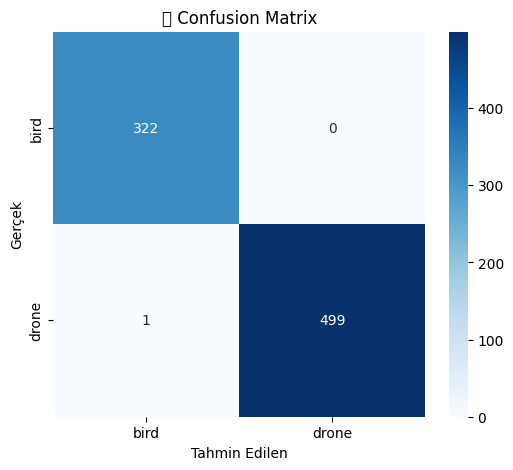

In [10]:
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Modeli yükle
model.load_state_dict(torch.load("best_model.pt"))
model.eval()

# Tahmin ve gerçek etiketleri topla
all_preds = []
all_labels = []

with torch.no_grad():
    for inputs, labels in val_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)

        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Sınıf isimlerini göster
print("Sınıflar:", class_names)

# Classification Report
print("\n📊 Classification Report:")
print(classification_report(all_labels, all_preds, target_names=class_names))

# Confusion Matrix
cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap="Blues", xticklabels=class_names, yticklabels=class_names)
plt.xlabel("Tahmin Edilen")
plt.ylabel("Gerçek")
plt.title("📌 Confusion Matrix")
plt.show()


📊 Classification Report:
              precision    recall  f1-score   support

        bird       1.00      1.00      1.00         5
       drone       1.00      1.00      1.00         5

    accuracy                           1.00        10
   macro avg       1.00      1.00      1.00        10
weighted avg       1.00      1.00      1.00        10



/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 129514 (\N{TEST TUBE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


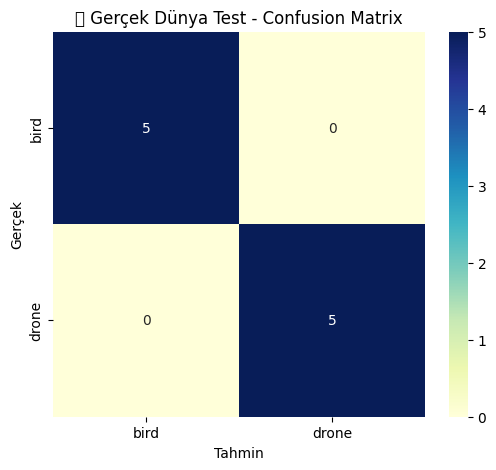

In [15]:
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import torch

# Preprocessing
test_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])

# 🔥 Sadece .jpg, .jpeg, .png olanları yüklesin
custom_test_data = datasets.ImageFolder(
    root="/content/custom_test",
    transform=test_transform,
    is_valid_file=lambda x: x.endswith((".jpg", ".jpeg", ".png"))
)
custom_test_loader = DataLoader(custom_test_data, batch_size=1, shuffle=False)

# Modeli yükle
model.load_state_dict(torch.load("best_model.pt", map_location=device))
model.eval()

# Tahmin et
all_preds = []
all_labels = []

with torch.no_grad():
    for inputs, labels in custom_test_loader:
        inputs = inputs.to(device)
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)

        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Sonuçları yazdır
print("📊 Classification Report:")
print(classification_report(all_labels, all_preds, target_names=custom_test_data.classes))

# Confusion Matrix
cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap="YlGnBu", xticklabels=custom_test_data.classes, yticklabels=custom_test_data.classes)
plt.xlabel("Tahmin")
plt.ylabel("Gerçek")
plt.title("🧪 Gerçek Dünya Test - Confusion Matrix")
plt.show()


In [14]:
!rm -r /content/custom_test/.ipynb_checkpoints || echo "Zaten yok"


In [11]:
!cp best_model.pt /content/drive/MyDrive/best_model_drone_bird.pt
